In [127]:
library(pacman)
# devtools::install_github("yanlinlin82/ggvenn")
p_load(tidyverse, remotes, forestploter, grid, cowplot, viridis,
       data.table, RColorBrewer, ComplexHeatmap, eulerr, ggvenn, XML,
      ggrepel, ggpubr)

### Figure 2

#### Function

In [13]:
## read Brain Cortex tissue GRN
read_tissue_map <- function() {
    dir <- "/mnt/projects/tissue_maps/Brain_Cortex/"
    res <- tibble()
    cortex_map <- file.path(list.files(dir, 
                            pattern = "significant_eqtls.txt", 
                            recursive = TRUE,
                            full.names = TRUE))
    res <- res %>%
            bind_rows(
                read_tsv(cortex_map, show_col_types = FALSE)) %>% 
            dplyr::select(snp, beta, beta_se, alt, ref, maf, eqtl_pval, 
                          gene, interaction_type) %>% 
            distinct()
} 

In [14]:
grn_eqtls <- read_tissue_map() %>% 
                dplyr::select(-interaction_type)
mr_strong_res <- read_tsv("../data/bcgrn_MR/cortex_grn_singlesnp_strong.txt",
                         show_col_types = FALSE)
mr_strong_afc <- read_tsv("../data/get_afc/significant_eqtls.txt",
                         show_col_types = FALSE)
mr_strong_res_with_afc <- mr_strong_res %>% 
    inner_join(mr_strong_afc %>% 
              dplyr::select(snp, gene, log2_aFC, log2_aFC_lower, log2_aFC_upper) %>% 
              distinct(), by = c("exposure" = "gene", "SNP" = "snp"))

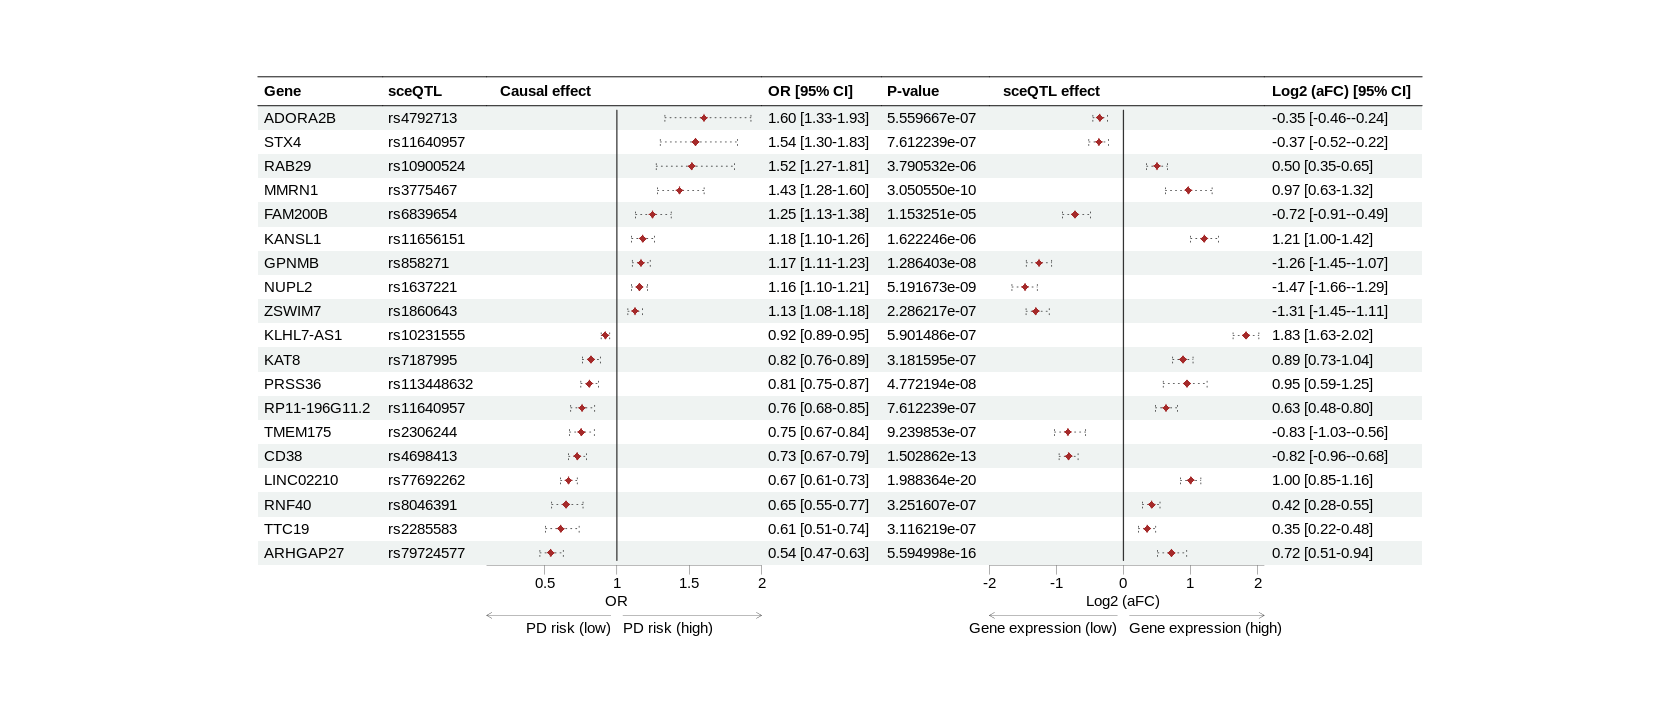

In [17]:
res_strong <- mr_strong_res_with_afc %>% 
    left_join(grn_eqtls %>% 
              dplyr::select(snp, gene, beta) %>% 
              distinct(), by = c("SNP" = "snp", "exposure" = "gene")) %>% 
    mutate(beta = round(beta, 4)) %>% 
    rename("sceQTL (b)" = "beta",
          "Gene" = "exposure",
          "sceQTL" = "SNP",
          "P-value" = "p") %>% 
    dplyr::select(-outcome, -id.exposure, -id.outcome, -samplesize, 
                  -b, -se, -lo_ci, -up_ci) %>% 
    # add columns with CI for MR estimate and log2_aFC
    mutate(`OR [95% CI]` = sprintf("%.2f [%.2f-%.2f]", or, or_lci95, or_uci95),
           `Log2 (aFC) [95% CI]` = sprintf("%.2f [%.2f-%.2f]", log2_aFC, log2_aFC_lower, 
                                  log2_aFC_upper)) %>% 
    add_column(`Causal effect`=paste(rep(" ", 22), collapse = "  "), 
               .before = "OR [95% CI]") %>% 
    add_column(`sceQTL effect`=paste(rep(" ", 22), collapse = "  "), 
               .before = "Log2 (aFC) [95% CI]") %>% 
    relocate(c(`Causal effect`, "OR [95% CI]", 
               `sceQTL effect`, "Log2 (aFC) [95% CI]"), .before = "or") %>% 
    relocate("P-value", .after = "OR [95% CI]") %>% 
    arrange(desc(`OR [95% CI]`))
# Set-up theme
tm <- forest_theme(base_size = 9,
                   refline_lty = "solid",
                   ci_pch = 23,
                   ci_col = "black",
                   ci_fill = "brown",
                   ci_lwd = 0.5,
                   ci_Theight = 0.3,
                   ci_alpha = 1,
                   ci_lty = 3,
                   xaxis_lwd = 0.25,
                   legend_value = c("1", "2"))
options(repr.plot.width = 14, repr.plot.height = 6)
p <- forest(res_strong[,c(1:7)],
            est = list(res_strong$or,
                       res_strong$log2_aFC),
            lower = list(res_strong$or_lci95,
                         res_strong$log2_aFC_lower), 
            upper = list(res_strong$or_uci95,
                         res_strong$log2_aFC_upper),
            ci_column = c(3, 6),
            ref_line = c(1, 0),
            arrow_lab = list(c("PD risk (low)", "PD risk (high)"),
                             c("Gene expression (low)", "Gene expression (high)")),
            xlim = list(c(0.1, 2), c(-2, 2.1)),
            xlab = c("OR", "Log2 (aFC)"),
            theme = tm)
p <- add_border(p, row = c(0,1), part = "header", gp = gpar(lwd = 0.75))
plot(p)

### Figure 3

#### Function

In [23]:
## read multimorbid3D results
# Read individual significant interaction files and put them into a single file
read_sig_inter_files <- function(fdir, levels) {
    res <- tibble()
    for (i in 0:levels) {
        fp <- file.path(fdir, paste0("level", i, "_sig_interactions.txt"))
        res <- res %>%
            bind_rows(
                read_tsv(fp, show_col_types = FALSE) %>%
                mutate(level = paste0("level", i))) %>%
                mutate(trait = if_else(grepl("Phosphatidylcholine", trait), 
                                       "Phosphatidylcholine levels*", trait),
                       trait = if_else(grepl("Phosphatidylserine", trait), 
                                       "Phosphatidylserine levels*", trait),
                       trait = if_else(grepl("Triacylglycerol", trait), 
                                       "Triacylglycerol levels*", trait),
                       trait = if_else(grepl("Cholesteryl ester", trait), 
                                       "Cholesteryl ester levels*", trait),
                       trait = if_else(grepl("Phosphatidylglycerol", trait), 
                                       "Phosphatidylglycerol levels*", trait),
                       trait = if_else(grepl("Phosphatidylethanolamine", trait),
                                       "Phosphatidylethanolamine levels*", trait),
                       trait = if_else(grepl("Phosphatidylinositol", trait), 
                                       "Phosphatidylinositol levels*", trait),
                       trait = if_else(grepl("Fatty acid", trait), 
                                       "Fatty acid levels*", trait),
                       trait = if_else(grepl("Lysophosphatidylcholine", trait),
                                       "Lysophosphatidylcholine levels*", trait),
                       trait = if_else(grepl("Lysophosphatidylethanolamine", trait),
                                       "Lysophosphatidylethanolamine levels*", trait),
                       trait = if_else(grepl("Phosphatidate", trait), 
                                       "Phosphatidate levels*", trait),
                       trait = if_else(grepl("Diacylglycerol", trait), 
                                       "Diacylglycerol levels*", trait),
                       trait = if_else(grepl("Sphingomyelin", trait), 
                                       "Sphingomyelin levels*", trait),
                       trait = if_else(grepl("Vaginal microbiome MetaCyc pathway", trait), 
                                       "Vaginal microbiome MetaCyc pathway*", trait))  %>%
        dplyr::select(-eqtl_type)
        }
    res
}

# read significant traits file (i.e., significant_enrichment_bootstrap.txt)
read_sig_enr_bootstrap_file <- function(fp) {
    traits <- read_tsv(fp, show_col_types = FALSE) %>% 
    dplyr::select(level, trait, trait_eqtls, sim_pval, adj_pval) %>% 
    arrange(level) %>% 
    distinct() %>% 
    mutate(trait = if_else(grepl("Phosphatidylcholine", trait), 
                       "Phosphatidylcholine levels*", trait),
           trait = if_else(grepl("Phosphatidylserine", trait), 
                      "Phosphatidylserine levels*", trait),
           trait = if_else(grepl("Triacylglycerol", trait), 
                      "Triacylglycerol levels*", trait),
           trait = if_else(grepl("Cholesteryl ester", trait), 
                      "Cholesteryl ester levels*", trait),
           trait = if_else(grepl("Phosphatidylglycerol", trait), 
                      "Phosphatidylglycerol levels*", trait),
           trait = if_else(grepl("Phosphatidylethanolamine", trait), 
                      "Phosphatidylethanolamine levels*", trait),
           trait = if_else(grepl("Phosphatidylinositol", trait), 
                      "Phosphatidylinositol levels*", trait),
           trait = if_else(grepl("Fatty acid", trait), 
                      "Fatty acid levels*", trait),
           trait = if_else(grepl("Lysophosphatidylcholine", trait), 
                      "Lysophosphatidylcholine levels*", trait),
           trait = if_else(grepl("Lysophosphatidylethanolamine", trait), 
                      "Lysophosphatidylethanolamine levels*", trait),
           trait = if_else(grepl("Phosphatidate", trait), 
                      "Phosphatidate levels*", trait),
           trait = if_else(grepl("Diacylglycerol", trait), 
                      "Diacylglycerol levels*", trait),
           trait = if_else(grepl("Sphingomyelin", trait), 
                      "Sphingomyelin levels*", trait),
           trait = if_else(grepl("Vaginal microbiome MetaCyc pathway", trait), 
                      "Vaginal microbiome MetaCyc pathway*", trait))
    }

#### Data (PD-associated network)

In [102]:
### read significant interactions file
snpi_inter <- read_sig_inter_files("../data/multimorbidity/assoc_net/", 3)

### read significant enrichment bootstrap file
snpi_traits <- read_sig_enr_bootstrap_file("../data/multimorbidity/assoc_net/significant_enrichment_bootstrap.txt")

### significant trait interactions subset
snp_sig_trait_inter <- snpi_inter %>%
    dplyr::select(-chromq, -posq, -rsidq, -chromt, -post, -rsidt, -corr, -dprime) %>%
    inner_join(snpi_traits %>%
               filter(sim_pval < 0.05), # retain only traits that passed sim pval < 0.05
               by = c("trait","level")) %>% 
    mutate(level = str_replace(level, "level", "L")) 

#### Data (PD-causal network)

In [103]:
### read significant interactions file
genei_inter <- read_sig_inter_files("../data/multimorbidity/causal_net/", 3)

### read significant enrichment bootstrap file
genei_traits <- read_sig_enr_bootstrap_file("../data/multimorbidity/causal_net/significant_enrichment_bootstrap.txt")

### significant trait interactions subset
gene_sig_trait_inter <- genei_inter %>%
    dplyr::select(-chromq, -posq, -rsidq, -chromt, -post, -rsidt, -corr, -dprime) %>%
    inner_join(genei_traits %>%
               filter(sim_pval < 0.05), # retain only traits that passed sim pval < 0.05
               by = c("trait","level")) %>% 
    mutate(level = str_replace(level, "level", "L"))

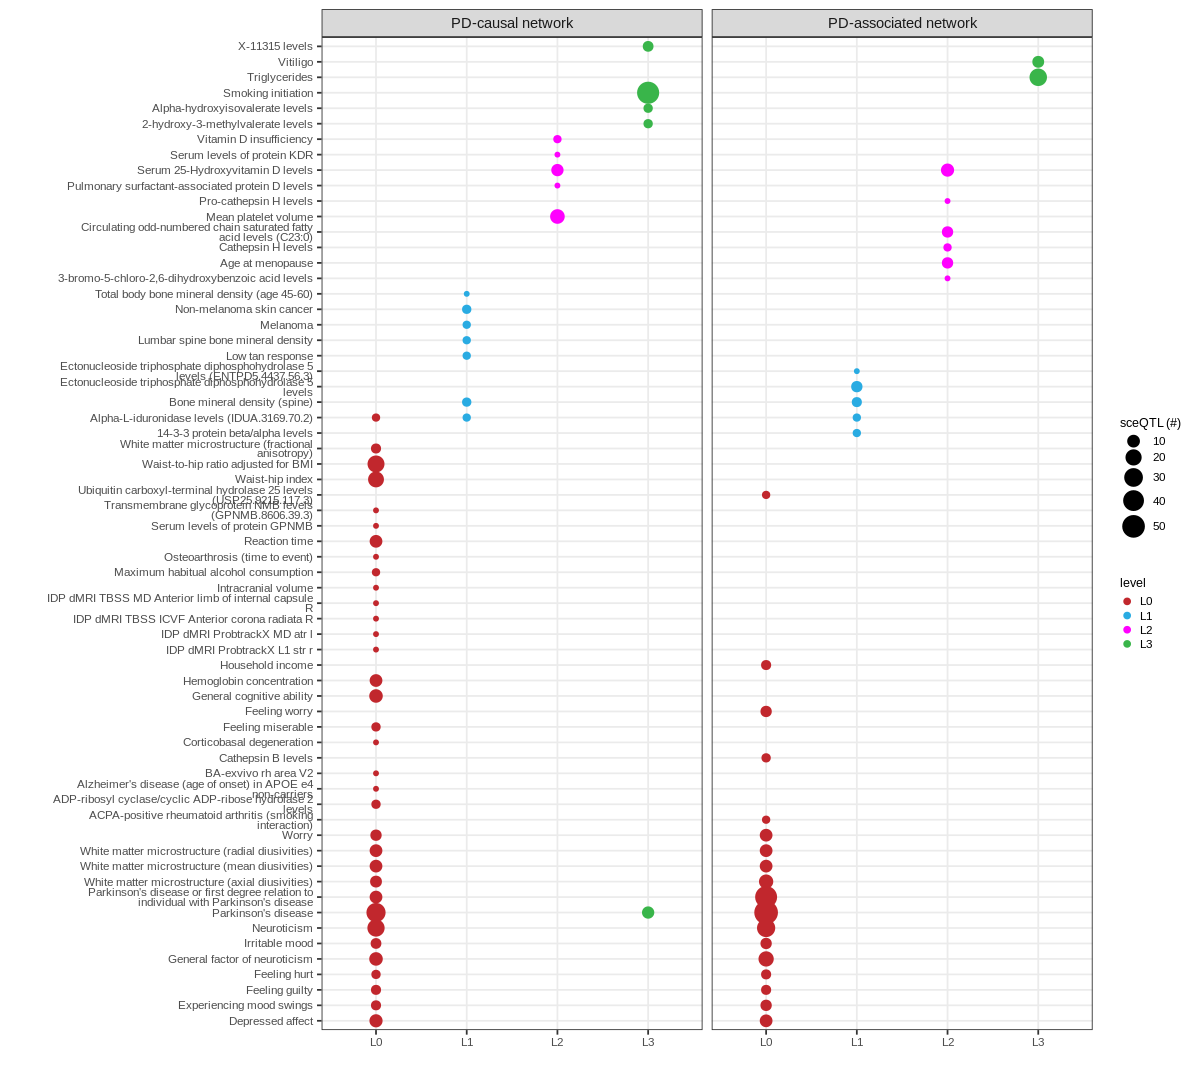

In [33]:
snp_traits_plot <- snp_sig_trait_inter %>% 
    dplyr::select(trait, level, trait_eqtls, adj_pval) %>% 
    distinct() %>% 
    mutate(group = "PD-associated network") 
gene_traits_plot <- gene_sig_trait_inter %>% 
    dplyr::select(trait, level, trait_eqtls, adj_pval) %>% 
    distinct() %>% 
    mutate(group = "PD-causal network")
combine_causal_assoc_network <- bind_rows(snp_traits_plot, gene_traits_plot)

traits_to_bottom <- c("Parkinson's disease", 
                      "Parkinson's disease or first degree relation to individual with Parkinson's disease",
                      "Neuroticism",
                      "Irritable mood",
                      "General factor of neuroticism",
                      "Feeling hurt",
                      "Feeling guilty",
                      "Experiencing mood swings",
                      "Depressed affect",
                      "Worry",
                      "White matter microstructure (radial diusivities)",
                      "White matter microstructure (mean diusivities)",
                      "White matter microstructure (axial diusivities)"
                     )
traits_above_bottom <-  c("Alpha−L−iduronidase levels (IDUA.3169.70.2)",
                          "Bone mineral density (spine)")

combine_causal_assoc_network$group_order <- factor(combine_causal_assoc_network$group,
        levels = c("PD-causal network", "PD-associated network"))
options(repr.plot.width = 10, repr.plot.height = 9)
combine_causal_assoc_network %>% 
    mutate(level_num = as.numeric(paste0(str_replace(level, "L", ""))),
           order = ifelse(trait %in% traits_to_bottom, -1, level_num),
          trait = fct_reorder(trait, order)) %>% 
    dplyr::select(-level_num, -order) %>% 
    ggplot(aes(level, trait, size = trait_eqtls, color = level)) +
    geom_point() +
    scale_y_discrete(name = "",
                    label = function(x) str_wrap(x, width = 50)) +
    scale_x_discrete(name = "") +
    scale_size_continuous(name= "sceQTL (#)") +
    scale_color_manual(values = c("#C1272D","#29ABE2","#FF00FF","#39B54A"))+
    theme_bw() +
    facet_grid(~group_order) +
    theme(axis.text.y = element_text(lineheight = 0.7),
         axis.text = element_text(size = 7),
         legend.text = element_text(size = 7),
         legend.title = element_text(size = 7.5),
         legend.key.size = unit(3, 'mm'))

### Figure 4A

In [52]:
gene_dat_df <- gene_sig_trait_inter %>% 
filter(level == "L0") %>% 
distinct() %>% 
dplyr::select(snp,trait,gene) %>% 
group_by(trait, gene) %>% 
mutate(n_snps = length(unique(snp))) %>% 
dplyr::select(-snp) %>% 
distinct()

snp_dat_df <- snp_sig_trait_inter %>% 
filter(!trait %like% "Parkin") %>% 
filter(level == "L0") %>% 
distinct() %>% 
dplyr::select(snp,trait,gene) %>% 
group_by(trait, gene) %>% 
mutate(n_snps = length(unique(snp))) %>% 
dplyr::select(-snp) %>% 
distinct()

gene_intersect <- intersect(gene_dat_df$gene, snp_dat_df$gene)

snp_dat_df <- snp_dat_df %>% 
filter(!gene %in% gene_intersect) %>% 
distinct() 

all_dat_df <- bind_rows(gene_dat_df, snp_dat_df) %>% 
    pivot_wider(names_from = gene, values_from = n_snps, values_fill = 0)
all_dat_df_mat <- as.matrix(all_dat_df[2:30])
rownames(all_dat_df_mat) <- all_dat_df$trait

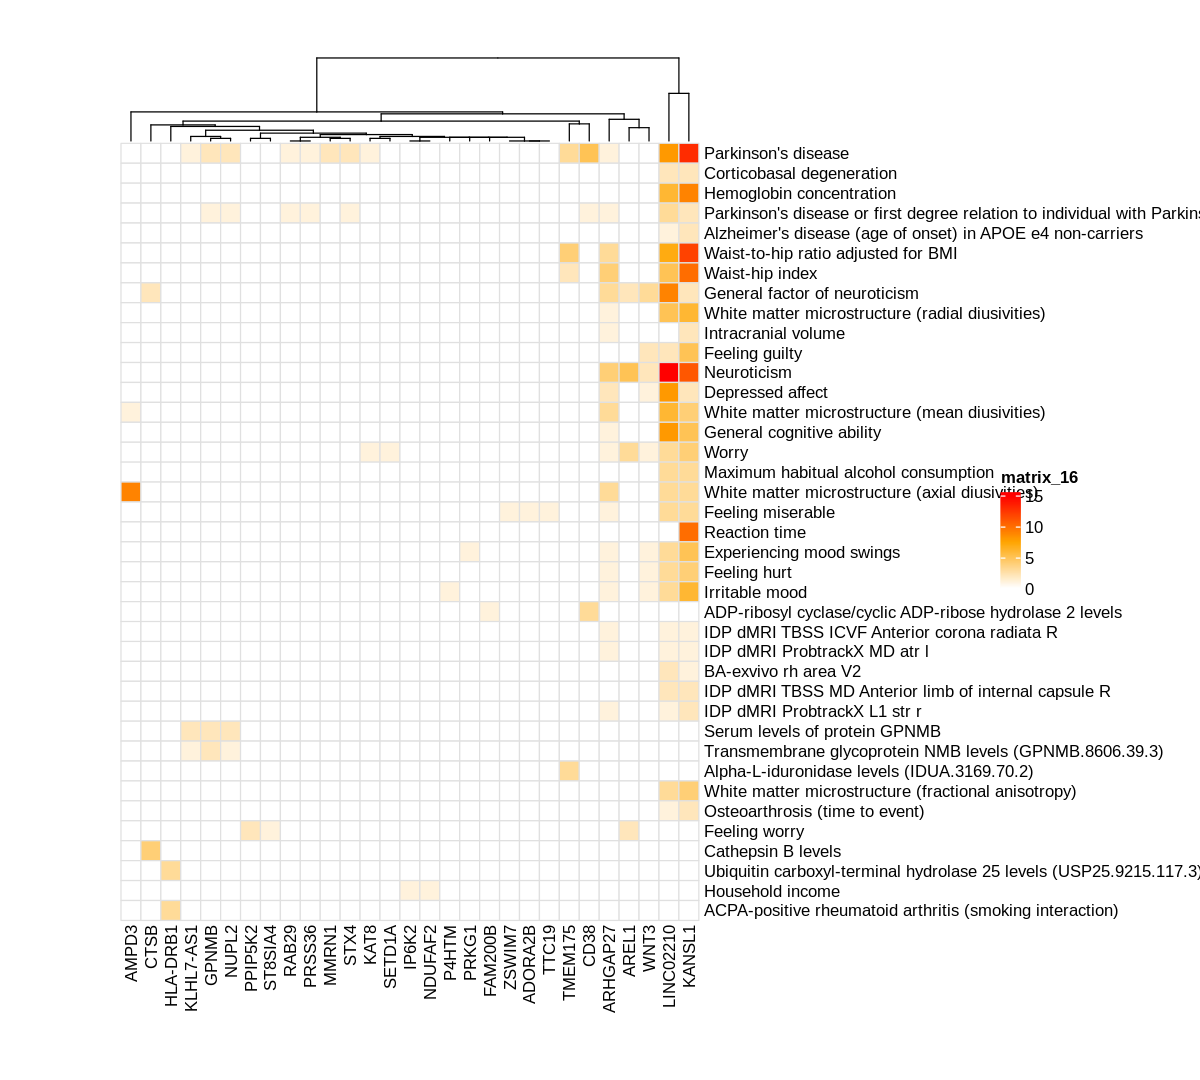

In [53]:
options(repr.plot.width = 10, repr.plot.height = 9)
pheatmap(all_dat_df_mat,
         color = colorRampPalette(c("white", "orange", "red"))(50),
         border_color = "grey88",
         cellwidth = 12, cellheight = 12,
         cluster_rows = FALSE, cluster_cols = TRUE, 
         clustering_distance_rows = "euclidean",
         clustering_distance_cols = "euclidean", 
         clustering_method = "complete",
         na_col = "white")

### Figure 5

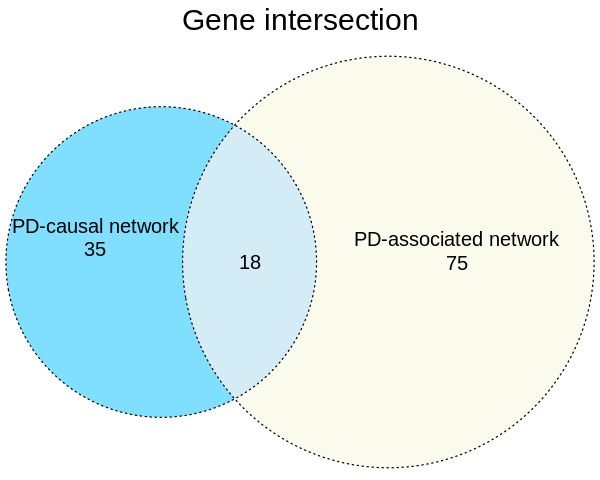

In [60]:
genes <- list("PD-causal network" = unique(gene_sig_trait_inter$gene),
            "PD-associated network" = unique(snp_sig_trait_inter$gene))
options(repr.plot.width = 5, repr.plot.height = 4)
plot(euler(genes, shape = "ellipse"),
     quantities = list(type = 'counts'),
    fills = list(fill = c("deepskyblue", "beige"), alpha = 0.5),
    labels = list(col = "black", font = 1, vjust = -1, hjust = -1),
    main = "Gene intersection",
    edges=list(lty = 3))

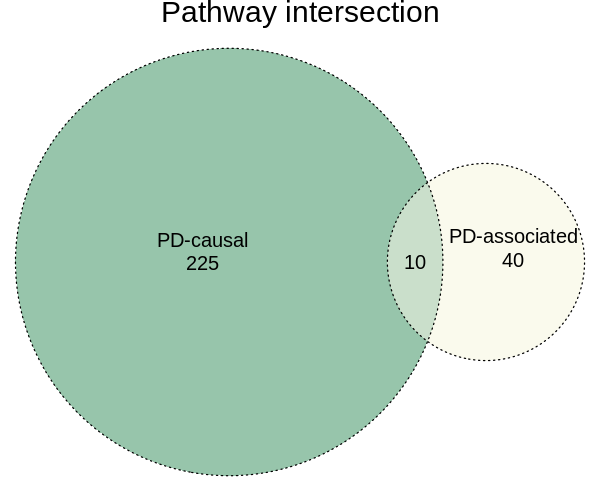

In [65]:
causalnet_path_res <- read_tsv("../data/pathways/gene_m3d_gprofiler_path_res.txt", show_col_types = FALSE) %>% 
    distinct()
assocnet_path_res <- read_tsv("../data/pathways/snp_m3d_gprofiler_path_res.txt", show_col_types = FALSE) %>% 
    distinct()
pathway_overlaps <- list(
    "PD-causal" = unique(causalnet_path_res$term_name),
    "PD-associated" = unique(assocnet_path_res$term_name)
)
plot(euler(pathway_overlaps, shape = "ellipse"),
     quantities = list(type = 'counts'),
    fills = list(fill = c("seagreen","beige"), alpha = 0.5),
    labels = list(col = "black", font = 1),
    main = "Pathway intersection",
    edges=list(lty = 3))

In [70]:
assocnet_gene_level_df <- snp_sig_trait_inter %>% 
    dplyr::select(gene, level) %>% 
    distinct()

causalnet_gene_level_df <- gene_sig_trait_inter %>% 
    dplyr::select(gene, level) %>% 
    distinct()

assocnet_pathways_subset <- assocnet_path_res %>% 
    dplyr::select(term_name, intersection) %>% 
    distinct() %>% 
    separate_rows(intersection, sep = ",") %>% 
    distinct() %>% 
    left_join(assocnet_gene_level_df, by = c("intersection" = "gene"))  

causalnet_pathways_subset <- causalnet_path_res %>% 
    dplyr::select(term_name, intersection) %>% 
    distinct() %>% 
    separate_rows(intersection, sep = ",") %>% 
    distinct() %>% 
    left_join(causalnet_gene_level_df, by = c("intersection" = "gene")) 

### number of pathways intersect between two groups 
pathway_intersect <- inner_join(assocnet_pathways_subset %>% 
                               dplyr::select(term_name) %>% 
                               distinct(), causalnet_pathways_subset %>% 
                               dplyr::select(term_name) %>% 
                               distinct(), by = "term_name")

get_intersect_path_info_assocnet <- assocnet_pathways_subset %>% 
    filter(term_name %in% pathway_intersect$term_name) %>% 
    distinct() %>% 
    group_by(term_name, level) %>% 
    mutate(gene_count = length(unique(intersection))) %>% 
    dplyr::select(-intersection) %>% 
    mutate(group = "PD-associated network") %>% 
    distinct()

get_intersect_path_info_causalnet <- causalnet_pathways_subset %>% 
    filter(term_name %in% pathway_intersect$term_name) %>% 
    distinct() %>% 
    group_by(term_name, level) %>% 
    mutate(gene_count = length(unique(intersection))) %>% 
    dplyr::select(-intersection) %>% 
    mutate(group = "PD-causal network") %>% 
    distinct()

# bind the above two dataframes
overlap_pathways_for_plotting <- bind_rows(get_intersect_path_info_assocnet,
                                           get_intersect_path_info_causalnet)

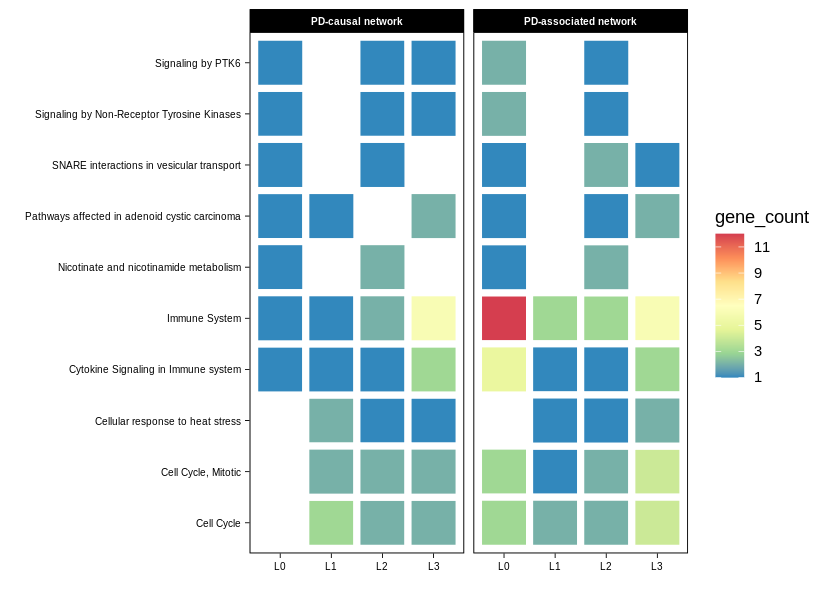

In [71]:
options(repr.plot.width = 7, repr.plot.height = 5)
overlap_pathways_for_plotting$group <- factor(overlap_pathways_for_plotting$group, 
        levels = c("PD-causal network",
                  "PD-associated network"))

overlap_pathways_for_plotting %>% 
ggplot(aes(level, term_name, fill = gene_count)) +
geom_tile(colour='white', linewidth = 2) +
scale_fill_distiller(palette = "Spectral",
                     direction = -1, na.value = "grey50", 
                     limits = c(1,12), 
                     breaks = seq(1,12,2)) +
scale_y_discrete(name = "",
                 label = function(x) str_wrap(x, width = 60)) +
labs(x="", y="Pathway description") +
coord_fixed() +
facet_grid(~group) +
theme_linedraw() +
theme(panel.grid = element_blank(),
      panel.background=element_rect(fill="white", colour="gray80"),
     axis.text = element_text(size = 6),
     strip.text.x = element_text(size = 6, face = "bold"))

### Figure 6

In [82]:
### DisGeNET Mappings
## map genes to diseases
g2d_all <- disgenet2r::gene2disease(
    gene = unique(gene_sig_trait_inter$gene),
    database = "CURATED",
    verbose  = TRUE
)

g2d_res <- g2d_all@qresult #%>% 
            # write_tsv("../data/DisGeNET/gene2disease_mapping_result.txt")

gene_list <- unique(g2d_all@qresult$gene_symbol)

# disease mapping downloaded from https://www.disgenet.org/static/disgenet_ap1/files/downloads/disease_mappings.tsv.gz
d_map <- fread("../data/DisGeNET/disease_mappings.tsv.gz",
              sep = "\t",
              nThread = 24)

## extract MeSH terms only
d_map_msh <- d_map %>% 
                filter(vocabulary == "MSH") %>% 
                dplyr::select(diseaseId, code, name) %>% 
                distinct()

# map disease to MeSH description
g2d_res <- read_tsv("../data/DisGeNET/gene2disease_mapping_result.txt",
                   show_col_types = FALSE) %>% 
            dplyr::select(score, disease_name, disease_class, gene_symbol, diseaseid) %>% 
            distinct()

g2d_res_mesh <- g2d_res %>% 
                inner_join(d_map_msh, by = c("diseaseid" = "diseaseId"))


In [137]:
# Cleaned comorbidity results 
comor <- read_tsv("../data/comoRbidity/pd_all_cleaned.txt",
                 show_col_types = FALSE)
## ICD's converted to MeSH
icd2snomedctus <- read_tsv("../data/comoRbidity/pd_cleaned_icd2snomedct_us.txt",
                         show_col_types = FALSE)
snomedctus2mesh <- read_tsv("../data/comoRbidity/pd_cleaned_snomedct_us2mesh.txt",
                          show_col_types = FALSE)
comor_dict <- snomedctus2mesh %>%
    mutate(mesh_id = ui,
          ui = NULL,
          source = NULL) %>% 
    rename(c("ui"="term", "mesh_name"="name")) %>%
    inner_join(icd2snomedctus %>% select(ui, term), by = "ui") %>%
    inner_join(comor, by = c("term"="threedigit"), 
               multiple = "all", 
               relationship = "many-to-many") %>%
    select(-ui) %>%
    distinct() %>%
    select(mesh_name, mesh_id, term, disAcode, descShort, 
           log10_or, log10_or_lower, log10_or_upper)

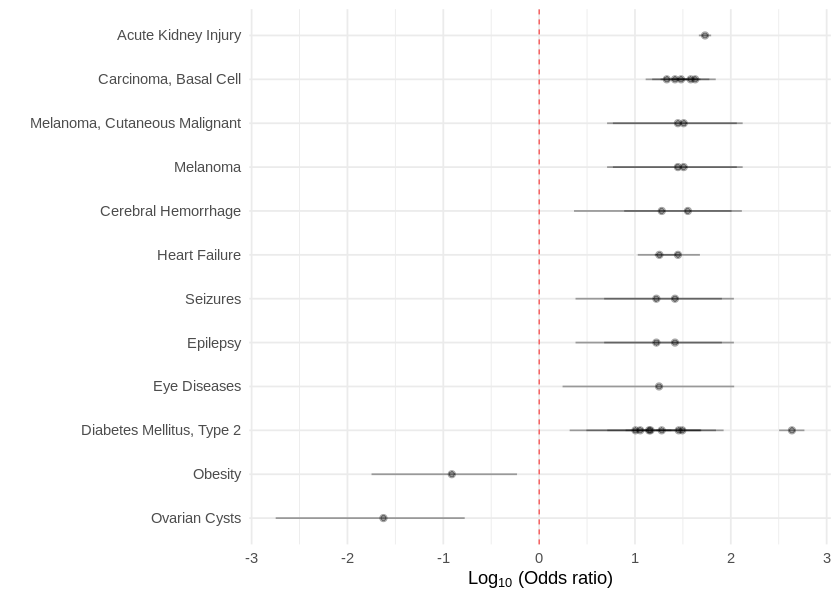

In [138]:
# merge comorbid and disgenet results
options(repr.plot.width = 5, repr.plot.height = 4)
idi_disgenet_overlaps <- g2d_res_mesh %>% 
    dplyr::select(code) %>% 
    distinct() %>% 
    inner_join(comor_dict, by = c("code" = "mesh_id"), multiple = "all") %>% 
    dplyr::select(mesh_name, log10_or, log10_or_lower, log10_or_upper) %>% 
    distinct() 

idi_disgenet_overlaps <- g2d_res_mesh %>% 
    dplyr::select(code) %>% 
    distinct() %>% 
    inner_join(comor_dict, by = c("code" = "mesh_id"), multiple = "all") %>% 
    distinct()

options(repr.plot.width = 7, repr.plot.height = 5)
idi_plot <- idi_disgenet_overlaps %>% 
    ggplot(aes(x = fct_reorder(mesh_name, log10_or), y = log10_or))+
    geom_pointrange(aes(ymin = log10_or_lower, ymax = log10_or_upper), alpha = 0.35,
                   size = 0.25)+
    geom_hline(yintercept = 0, colour = "red", linetype = "dashed", lwd = 0.25)+    
    coord_flip()+
    theme_minimal()+
    labs(x = "", y = expression(Log[10]~"(Odds ratio)"))
plot(idi_plot)

### Supplementary Figure 1

#### Functions

In [107]:
## Read Brain Cortex tissue map (significant_eqtls.txt)
read_tissue_sig_eqtls <- function(dir_path) {
    res <- tibble()
    cortex_map <- file.path(list.files(dir_path, 
                            pattern = "significant_eqtls.txt", 
                            recursive = TRUE,
                            full.names = TRUE))
    res <- res %>%
            bind_rows(
                read_tsv(cortex_map, show_col_types = FALSE)) %>% 
                dplyr::select(snp, snp_chr, snp_locus, beta, beta_se, alt, ref, maf, 
                              eqtl_pval, gene, interaction_type, gene_chr, gencode_id) %>% 
                distinct()
}

## Read Brain Cortex tissue input (snps.txt)

read_input_snps <- function(dir_path) {
    res <- tibble()
    snps <- file.path(list.files(dir_path, 
                            pattern = "snps.txt", 
                            recursive = TRUE,
                            full.names = TRUE))
    res <- res %>%
            bind_rows(
                read_tsv(snps, show_col_types = FALSE)) %>% 
                dplyr::select(snp) %>% 
                distinct()
}

## function ot read each significant_eqtl.txt on each chromosome and count number of snp-gene pairs

read_tissue_sig_pairs <- function() {
    dir_path = "../../../../tissue_maps/Brain_Cortex/"
    res <- tibble()
    cortex_map <- file.path(list.files(dir_path, 
                            pattern = "significant_eqtls.txt", 
                            recursive = TRUE,
                            full.names = TRUE))
    for (chr in cortex_map){
        chr_name <- basename(dirname(chr))
        chr_df <- read_tsv(chr, show_col_types = FALSE) %>% 
                dplyr::select(snp,gene) %>% 
                mutate(pairs = paste0(snp, "_", gene)) %>% 
                add_column("chr"=chr_name) %>% 
                distinct()
        res <- res %>% 
            bind_rows(chr_df)
    }
    count_pairs_df <- res %>% 
                        group_by(chr) %>% 
                        summarise(pairs_count = length(pairs))
}

In [109]:
# cortex map
cortex_grn <- read_tissue_sig_eqtls("/mnt/projects/tissue_maps/Brain_Cortex/")
length(unique(cortex_grn$snp)) 
length(unique(cortex_grn$gene)) 

[1] 862963

[1] 14427

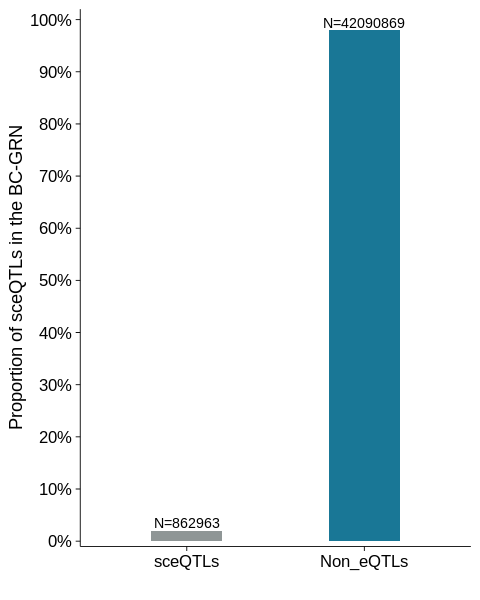

In [114]:
spatial_eQTLs = 862963
non_eQTLs = 42953832-spatial_eQTLs

eqtls <- data.frame("Category" = c("sceQTLs", "Non_eQTLs"),
                         "Count" = c(spatial_eQTLs, non_eQTLs)) %>% 
                mutate("Prop" = Count / sum(Count))

options(repr.plot.width = 4, repr.plot.height = 5)
ggplot(eqtls, aes(factor(Category, levels = c("sceQTLs", "Non_eQTLs")),
                  Prop, 
                  fill = factor(Category, 
                                levels = c("sceQTLs", "Non_eQTLs")))) +
  geom_bar(stat = "identity", width = 0.4, alpha = 0.9) +
  geom_text(aes(label= paste0("N=", Count)), position=position_dodge(width=0.8), 
            vjust=-0.25, size = 3) +
  labs(x = "", y = "Proportion of sceQTLs in the BC-GRN") +
  scale_y_continuous(labels = function(x) paste0(x*100, "%"), limits = c(0,1.01),
                     breaks = seq(0,1.01,by=0.10), expand = c(0.01,0)) +
  scale_fill_manual(values = c("azure4", "deepskyblue4"))+
  theme_classic() +
  theme(legend.position = "none",
        axis.text = element_text(size = 10, color = "black"),
        axis.title = element_text(size = 11),
        axis.line = element_line(linewidth = 0.25, colour = "black"),
        axis.ticks = element_line(linewidth = 0.25, colour = "black"))

no_of_targets_len,No_of_reg_eqtls
<dbl>,<chr>
1,709796
2,125066
3,23146
4,4152
5,697
6,94
7,12


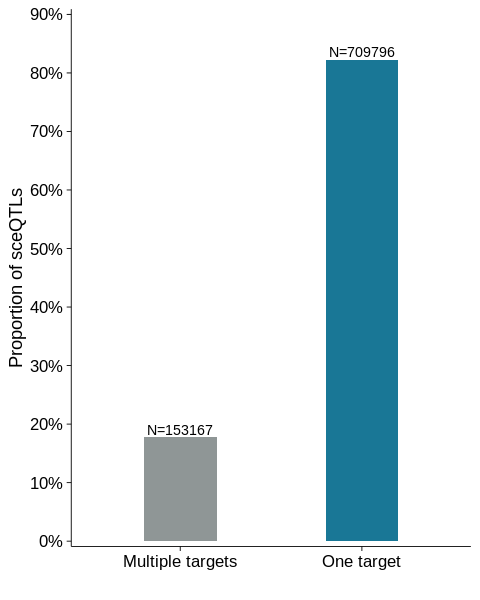

In [117]:
## subset snp and gene column
reg_pairs <- cortex_grn %>% 
    dplyr::select(snp, gene) %>% 
    distinct() %>% 
    group_by(snp) %>% 
    ## Find number of genes regulated by each snp
    dplyr::summarise(no_of_targets = paste(sort(unique(gene)), collapse=","),
                     no_of_targets_len = as.numeric(paste(length(unique(gene))))) %>% 
    ## Find number of snps regulate 1,2,3,4... genes
    group_by(no_of_targets_len) %>% 
    dplyr::summarise(No_of_reg_eqtls = paste(length(unique(snp))))
reg_pairs

reg_snp_df <- data.frame("Gene_targets" = c("Multiple targets", "One target"),
                         "No_of_sceQTLs" = c(153167, 709796))

## calculate proportion of eqtls
reg_snp_df_prop <- reg_snp_df %>% 
  mutate(prop = No_of_sceQTLs / sum(No_of_sceQTLs))

options(repr.plot.width = 4, repr.plot.height = 5)
ggplot(reg_snp_df_prop, aes(factor(Gene_targets, levels = c("Multiple targets", "One target")),
                            prop, 
                            fill = factor(Gene_targets, 
                                          levels = c("Multiple targets", "One target")))) +
  geom_bar(stat = "identity", width = 0.4, alpha = 0.9) +
  geom_text(aes(label= paste0("N=", No_of_sceQTLs)), position=position_dodge(width=0.8), 
            vjust=-0.25, size = 3) +
  labs(x = "", y = "Proportion of sceQTLs") +
  scale_y_continuous(labels = function(x) paste0(x*100, "%"), limits = c(0,0.9),
                     breaks = seq(0,1,by=0.10), expand = c(0.01,0)) +
  scale_fill_manual(values = c("azure4", "deepskyblue4"))+
  theme_classic() +
  theme(legend.position = "none",
        axis.text = element_text(size = 10, color = "black"),
        axis.title = element_text(size = 11),
        #legend.text = element_text(size = 7),
        #legend.title = element_text(size = 8, face = "bold"),
        axis.line = element_line(linewidth = 0.25, colour = "black"),
        axis.ticks = element_line(linewidth = 0.25, colour = "black"))

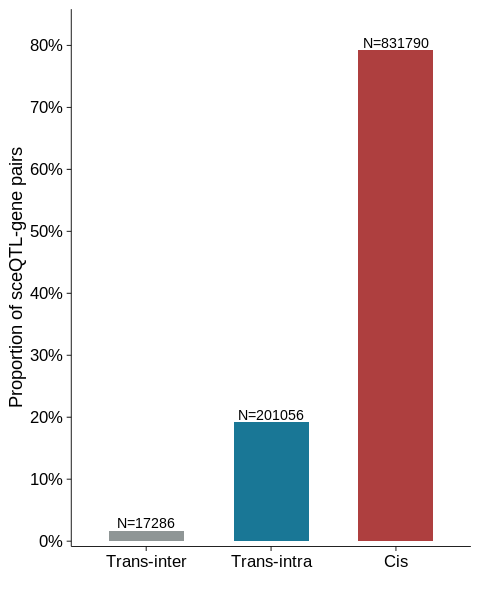

In [120]:
cis_trans_prop <- cortex_grn %>% 
                    dplyr::select(snp, gene, interaction_type) %>% 
                    mutate(pairs = paste0(snp, "_", gene)) %>% 
                    group_by(interaction_type) %>% 
                    summarise(count = length(pairs)) %>% 
                    mutate(prop = count/sum(count),
                          interaction_type = str_replace_all(
                              interaction_type, c("Trans-interchromosomal" = "Trans-inter", 
                                                  "Trans-intrachromosomal" = "Trans-intra")))

options(repr.plot.width = 4, repr.plot.height = 5)
ggplot(cis_trans_prop, aes(factor(interaction_type, levels = c("Trans-inter", 
                                                               "Trans-intra",
                                                              "Cis")),
                            prop, 
                            fill = factor(interaction_type, levels = c("Trans-inter", 
                                                               "Trans-intra",
                                                              "Cis")))) +
  geom_bar(stat = "identity", width = 0.6, alpha = 0.9) +
  geom_text(aes(label= paste0("N=", count)), position=position_dodge(width=0.8), 
            vjust=-0.25, size = 3) +
  labs(x = "", y = "Proportion of sceQTL-gene pairs") +
  scale_y_continuous(labels = function(x) paste0(x*100, "%"), limits = c(0,0.85),
                     breaks = seq(0,1,by=0.10), expand = c(0.01,0)) +
  scale_x_discrete(label = function(x) str_wrap(x, width = 30)) +
  scale_fill_manual(values = c("azure4", "deepskyblue4", "brown"))+
  theme_classic() +
  theme(legend.position = "none",
        axis.text = element_text(size = 10, color = "black"),
        axis.title = element_text(size = 11),
        axis.line = element_line(linewidth = 0.25, colour = "black"),
        axis.ticks = element_line(linewidth = 0.25, colour = "black"))

`geom_smooth()` using formula = 'y ~ x'


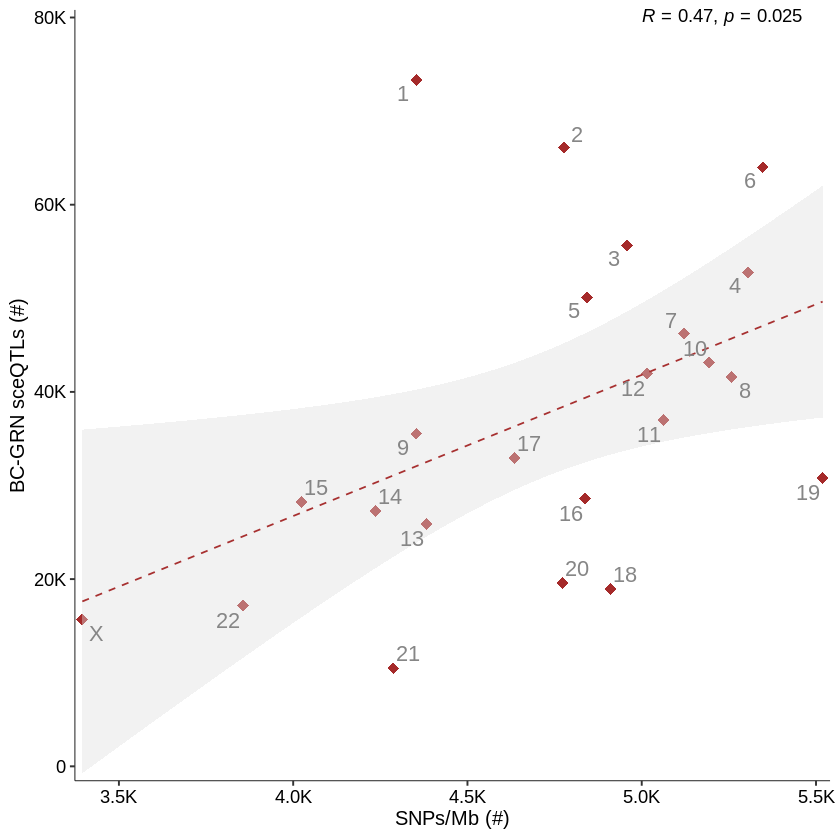

In [134]:
counts_df <- read_tsv("../data/bcgrn/gene_snp_count_stats.txt",
                     show_col_types = FALSE) %>% 
             mutate(chr = gsub("chr", "", chr))

counts_df$chr <- factor(counts_df$chr, levels = c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,
                                              19,20,21,22,"X"))

options(repr.plot.width = 7, repr.plot.height = 7)
counts_df %>% ggplot(aes(snp_density, grn_snp_count)) +
    geom_point(pch=18, size = 3, color = "brown", alpha = 1) +
    geom_smooth(method = "lm",
                color="#A73030FF",
                fill="gray88",
                size = 0.5,
                linetype = "dashed") +
    geom_text_repel(aes(label = chr),
                    min.segment.length = 0,
                    box.padding   = 0.20,
                    point.padding = 0.7,
                    segment.color = 'grey50',
                    max.overlaps = 30,
                    size = 4.6,
                    stat = "identity",
                    color = "#868686FF") +
    stat_cor(method = "pearson", label.x = 5000, label.y = 80000, size = 3.9) +
    scale_x_continuous(name = "SNPs/Mb (#)",
                       labels = scales::label_number_si(accuracy = 0.5),
                       expand = c(0.01,0.01)) +
    scale_y_continuous(name = "BC-GRN sceQTLs (#)",
                       labels = scales::label_number_si(),
                       expand = c(0.01,0.01)) +
    theme_classic2() +
    theme(axis.line = element_line(linewidth = 0.25),
          axis.text = element_text(size = 11, color = "black"),
          axis.title = element_text(size = 12, color = "black")) 

`geom_smooth()` using formula = 'y ~ x'


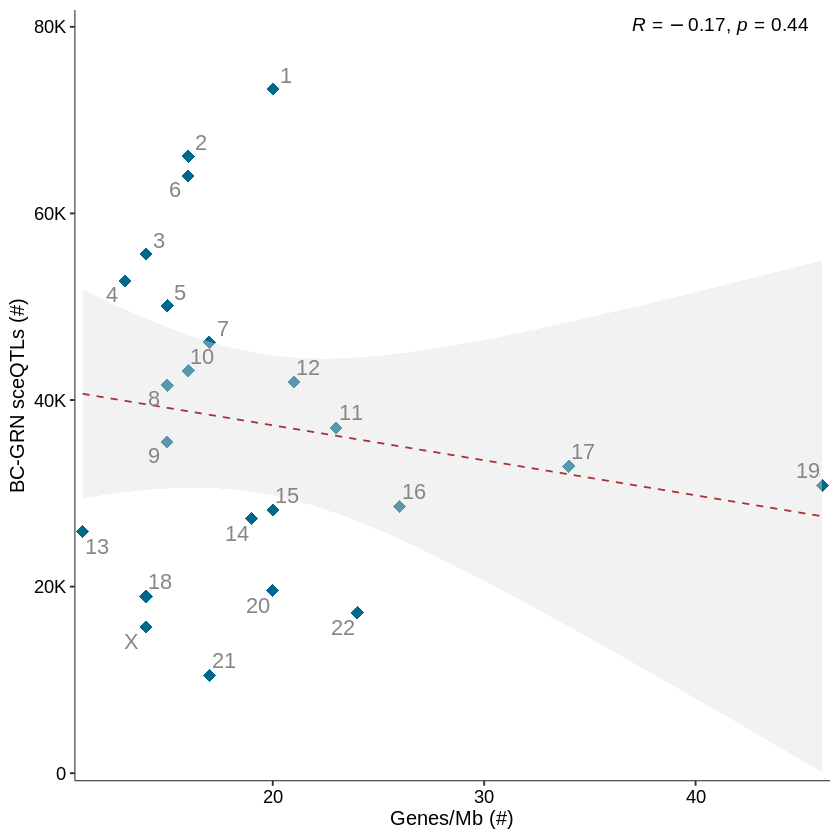

In [135]:
counts_df %>% ggplot(aes(gene_density, grn_snp_count)) +
    geom_point(pch=18, size = 3.4, color = "deepskyblue4", alpha = 1) +
    geom_smooth(method = "lm",
                color="#A73030FF",
                fill="gray88",
                size = 0.5,
                linetype = "dashed") +
    geom_text_repel(aes(label = chr),
                    min.segment.length = 0,
                    box.padding   = 0.20,
                    point.padding = 0.7,
                    max.overlaps = 30,
                    size = 4.6,
                    color = "#868686FF") +
    stat_cor(method = "pearson", label.x = 37, label.y = 80000, size = 4) +
    scale_x_continuous(name = "Genes/Mb (#)",
                       expand = c(0.01,0.01)) +
    scale_y_continuous(name = "BC-GRN sceQTLs (#)",
                       limits = c(0,81000), breaks = seq(0,81000,20000),
                       labels = scales::label_number_si(),
                       expand = c(0.01,0.01)) +
    theme_classic2() +
    theme(axis.line = element_line(linewidth = 0.25),
          axis.text = element_text(size = 11, color = "black"),
          axis.title = element_text(size = 12, color = "black")) 

### Supplementary Figure 2

In [104]:
## summary statistics pre- and post-bootstrap - PD-associated network
# pre bootstrap summary (PD-associated network)
snpi_inter <- read_sig_inter_files("../data/multimorbidity/assoc_net/", 5)
#significant trait interactions subset
snp_sig_trait_inter <- snpi_inter %>%
    dplyr::select(-chromq, -posq, -rsidq, -chromt, -post, -rsidt, -corr, -dprime) %>%
    inner_join(snpi_traits %>%
               filter(sim_pval < 0.05), # retain only traits that passed sim pval < 0.05
               by = c("trait","level")) %>% 
    mutate(level = str_replace(level, "level", "L")) 
snp_pre_bootstrap_summary <- snpi_inter %>% 
    dplyr::select(snp, trait, gene, level) %>% 
    mutate(level = str_replace(level, "level", "L")) %>% 
    group_by(level) %>% 
    summarise(SNPs = n_distinct(snp),
              Genes = n_distinct(gene),
              Traits = n_distinct(trait)) %>% 
    mutate(sim = "pre_bootstrap") %>% 
    pivot_longer(cols = c(SNPs, Genes, Traits), 
                 names_to = "category", 
                 values_to = "count")
# pre bootstrap summary (PD-causal network)
genei_inter <- read_sig_inter_files("../data/multimorbidity/causal_net/", 5)
#significant trait interactions subset
gene_sig_trait_inter <- genei_inter %>%
    dplyr::select(-chromq, -posq, -rsidq, -chromt, -post, -rsidt, -corr, -dprime) %>%
    inner_join(genei_traits %>%
               filter(sim_pval < 0.05), # retain only traits that passed sim pval < 0.05
               by = c("trait","level")) %>% 
    mutate(level = str_replace(level, "level", "L"))
gene_pre_bootstrap_summary <- genei_inter %>% 
    dplyr::select(snp, trait, gene, level) %>% 
    mutate(level = str_replace(level, "level", "L")) %>% 
    group_by(level) %>% 
    summarise(SNPs = n_distinct(snp),
              Genes = n_distinct(gene),
              Traits = n_distinct(trait)) %>% 
    mutate(sim = "pre_bootstrap") %>% 
    pivot_longer(cols = c(SNPs, Genes, Traits), 
                 names_to = "category", 
                 values_to = "count")

#post bootstrap summary (PD-associated network)
snp_post_bootstrap_summary <- snp_sig_trait_inter %>%
                            dplyr::select(trait, gene, snp, level) %>%
                            group_by(level) %>%
                            summarise(SNPs = n_distinct(snp),
                                      Genes = n_distinct(gene),
                                      Traits = n_distinct(trait)) %>%
                            mutate(sim = "post_bootstrap") %>%
                            pivot_longer(cols = c(SNPs, Genes, Traits), 
                                         names_to = "category", 
                                         values_to = "count")
#post bootstrap summary (PD-causal network)
gene_post_bootstrap_summary <- gene_sig_trait_inter %>%
                            dplyr::select(trait, gene, snp, level) %>%
                            group_by(level) %>%
                            summarise(SNPs = n_distinct(snp),
                                      Genes = n_distinct(gene),
                                      Traits = n_distinct(trait)) %>%
                            mutate(sim = "post_bootstrap") %>%
                            pivot_longer(cols = c(SNPs, Genes, Traits), 
                                         names_to = "category", 
                                         values_to = "count")
## plot pre- and post-bootstrap summary (PD-associated network)
options(repr.plot.width = 6.5, repr.plot.height = 6)
snp_sum_stats <- snp_pre_bootstrap_summary %>%
    bind_rows(snp_post_bootstrap_summary) %>%
    ggplot(aes(x = level, y = count, colour = category, group = sim, linetype = sim)) +
    geom_point(size = 1) +
    geom_line(linewidth = 0.5) +
    scale_color_manual(values = c("#A73030FF", "#003C67FF", "#868686FF")) +
    labs(x = "Levels", y = "Count", linetype = "", colour = "") +
    facet_grid(vars(category), scales = "free_y") +
    theme_light() +
    theme(strip.background =element_rect(fill="grey"),
          strip.text = element_text(colour = 'black'),
          legend.position = "bottom")
## plot pre- and post-bootstrap summary (PD-causal network)
options(repr.plot.width = 6.5, repr.plot.height = 6)
gene_sum_stats <- gene_pre_bootstrap_summary %>%
    bind_rows(gene_post_bootstrap_summary) %>%
    ggplot(aes(x = level, y = count, colour = category, group = sim, linetype = sim)) +
    geom_point(size = 1) +
    geom_line(linewidth = 0.5) +
    scale_color_manual(values = c("#A73030FF", "#003C67FF", "#868686FF")) +
    labs(x = "Levels", y = "Count", linetype = "", colour = "") +
    facet_grid(vars(category), scales = "free_y") +
    theme_light() +
    theme(strip.background =element_rect(fill="grey"),
          strip.text = element_text(colour = 'black'),
          legend.position = "bottom")

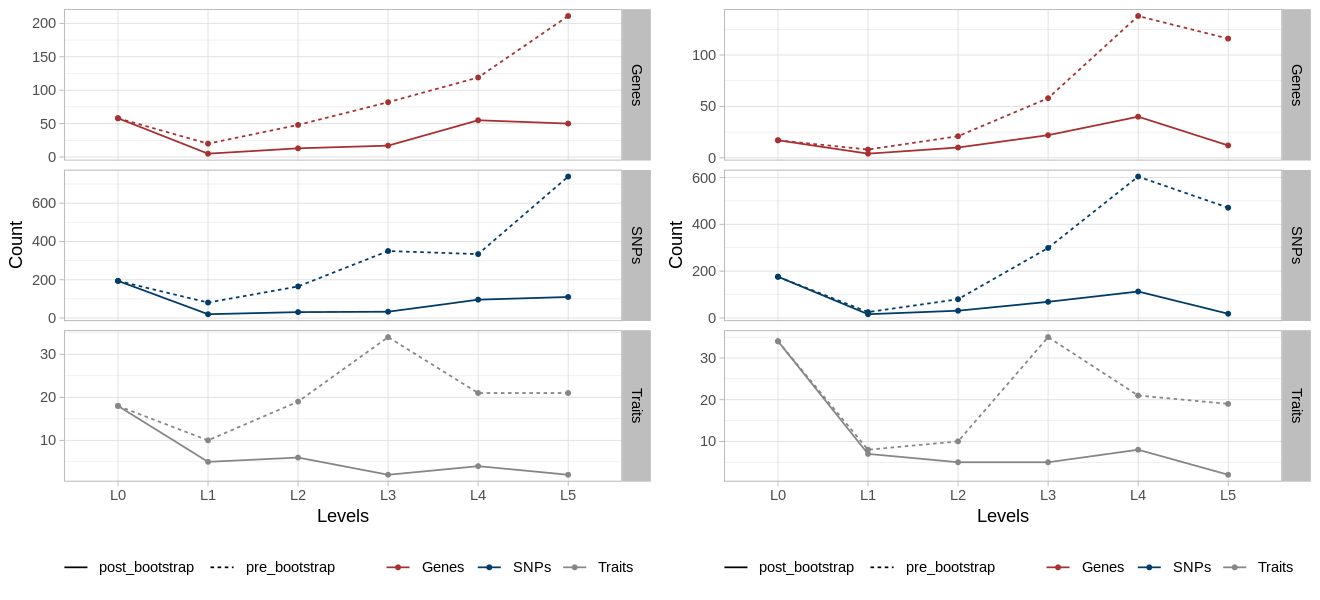

In [105]:
options(repr.plot.width = 11, repr.plot.height = 5)
cowplot::plot_grid(snp_sum_stats,
                   gene_sum_stats, 
                   nrow = 1,
                   labels = "")